In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import missingno as msn
import random

import matplotlib.pyplot as plt
import seaborn as sns

# Plot options
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn')
%matplotlib inline

# Clustering
from sklearn.preprocessing import StandardScaler
import yellowbrick
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as shc

# Other options
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('../data/processed/london_2013.csv', parse_dates=['DateTime'])
df.drop(['stdorToU', 'date', 'time'], 1, inplace=True)
df.head()

,DateTime,LCLid,stdorToU,consumption,date,time
0,2013-01-01 00:00:00,MAC000003,Std,1.966,2013-01-01,00:00:00
1,2013-01-01 00:30:00,MAC000003,Std,1.922,2013-01-01,00:30:00
2,2013-01-01 01:00:00,MAC000003,Std,1.808,2013-01-01,01:00:00
3,2013-01-01 01:30:00,MAC000003,Std,0.795,2013-01-01,01:30:00
4,2013-01-01 02:00:00,MAC000003,Std,1.235,2013-01-01,02:00:00


## Clustering of household using hourly load patterns over the whole day

* Resampling to hour and take the sum of consumption per 30 minutes
* Calculate average load per specific hour for all households, in this case, the median
* Run kmeans and agglomertive clustering to see  

In [15]:
# Resampling to hour
df_hour = df.groupby('LCLid').resample('H', on='DateTime').sum().reset_index()

# Extracting necessary variables
df_hour['date'] = df_hour['DateTime'].apply(lambda x: x.date())
df_hour['hour'] = df_hour['DateTime'].apply(lambda x: x.hour)

# Aggregate
df_hour = df_hour.groupby(['LCLid', 'hour'])['consumption'].median().reset_index()

In [16]:
X = df_hour.pivot_table(index='LCLid', columns='hour', values='consumption')

### K-Means clustering


In [19]:
scaler = StandardScaler().fit(X)

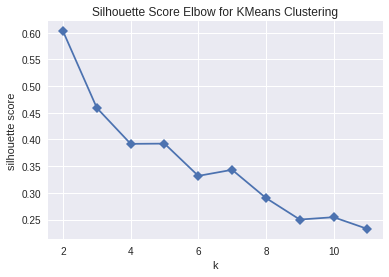

In [25]:
# Instantiate the clustering model and visualizer
yellowbrick.style.rcmod.reset_orig()
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), timings=False, metric='silhouette')

visualizer.fit(StandardScaler().fit_transform(X))    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [47]:
kmeans = KMeans(n_clusters=4, max_iter=1000).fit(scaler.transform(X))

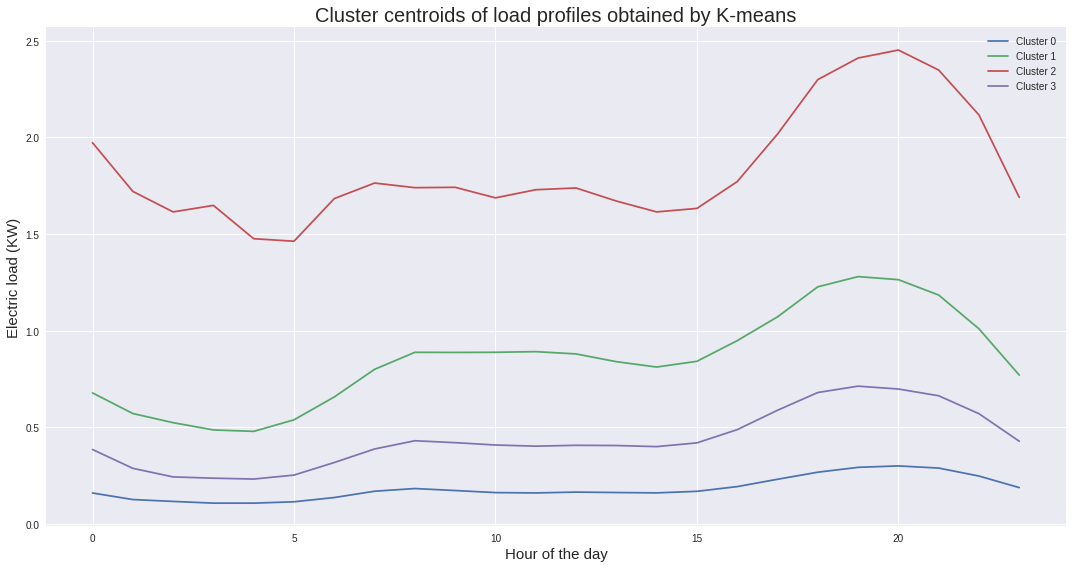

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
for i in range(0,kmeans.n_clusters):
    ax.plot(np.arange(0,24), scaler.inverse_transform(kmeans.cluster_centers_[i]), label='Cluster {c}'.format(c=i))

ax.set_title('Cluster centroids of load profiles obtained by K-means', size=20)
ax.set_xlabel('Hour of the day', size=15)
ax.set_ylabel('Electric load (KW)', size=15)
ax.legend()
fig.tight_layout()

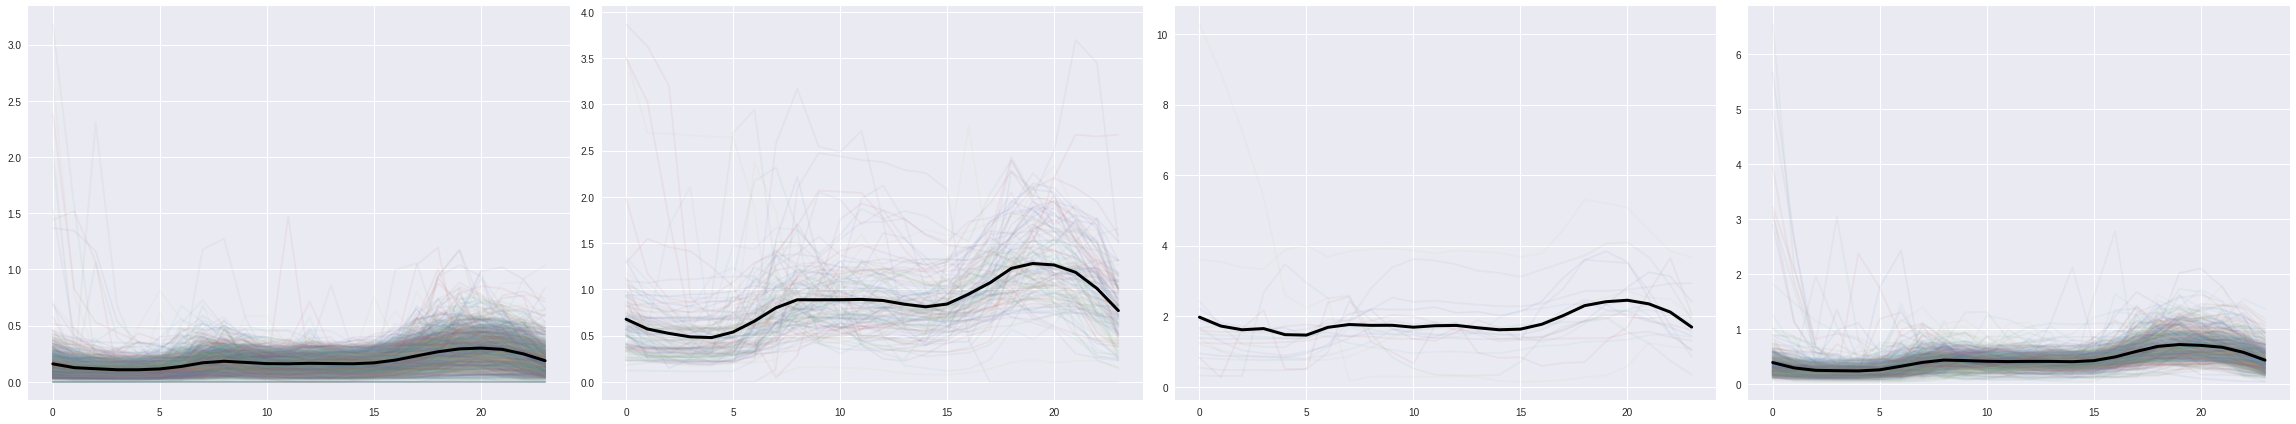

In [49]:
X_cluster= X.copy()
X_cluster['label'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(8*kmeans.n_clusters,6), ncols=kmeans.n_clusters)

for c in range(0,kmeans.n_clusters):
    df_plot = X_cluster[X_cluster.label == c].drop('label', 1).T

    ax[c].plot(df_plot, alpha=0.07)
    ax[c].plot(np.arange(0,24,1), scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    # ax[c].set_ylim(0,7)
fig.tight_layout()

### Agglomertive clustering

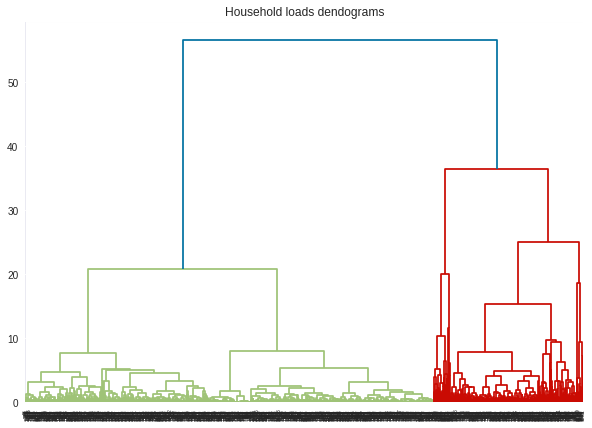

In [50]:
plt.figure(figsize=(10, 7))  
plt.title("Household loads dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  

In [51]:
agg = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
agg.fit(X)  

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

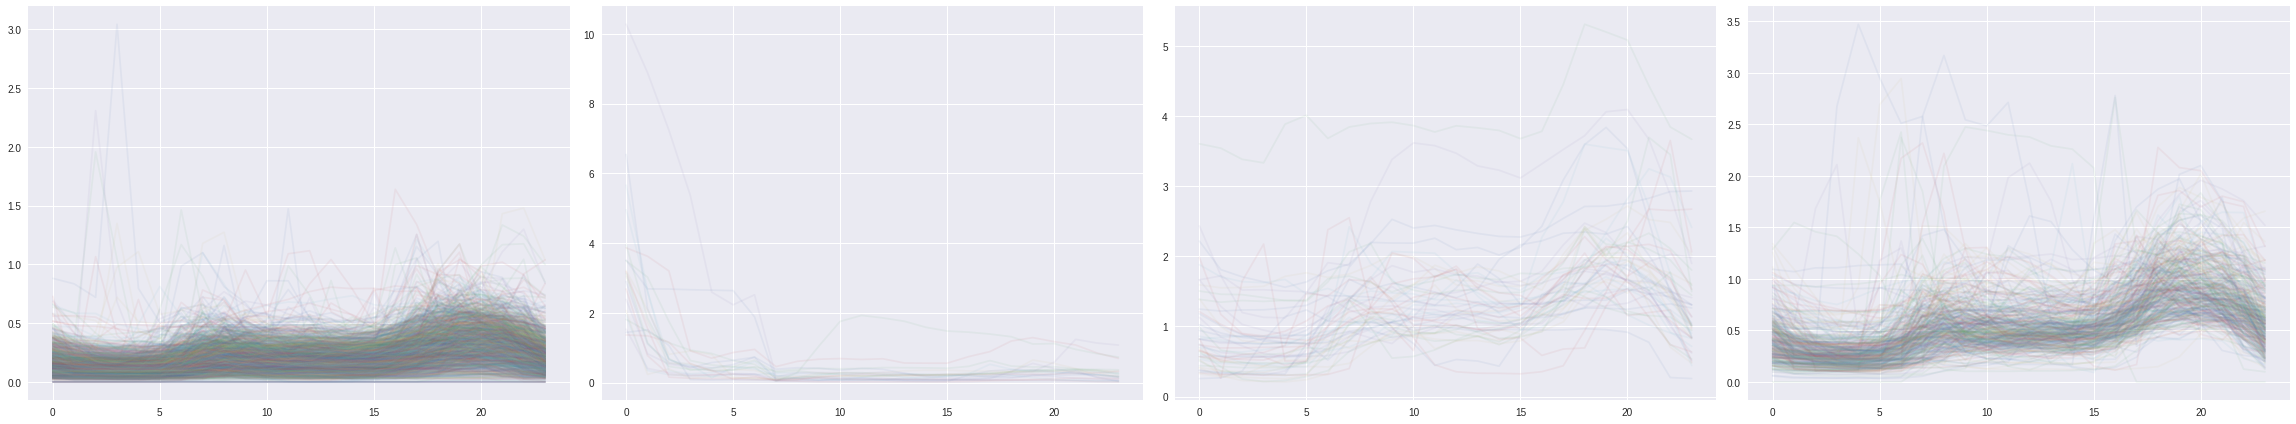

In [53]:
X_cluster= X.copy()
X_cluster['label'] = agg.labels_

fig, ax = plt.subplots(figsize=(8*agg.n_clusters,6), ncols=agg.n_clusters)

for c in range(0,agg.n_clusters):
    df_plot = X_cluster[X_cluster.label == c].drop('label', 1).T

    ax[c].plot(df_plot, alpha=0.07)
   #  ax[c].plot(np.arange(0,24,1), scaler.inverse_transform(kmeans.cluster_centers_[c]), linewidth=3, label='Cluster {c}'.format(c=c), color='black')
    # ax[c].set_ylim(0,7)
fig.tight_layout()

## Clustering based on load indicators